# Example Flow to Modeling

## Import modules

In [1]:
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from PipelineChallenge import split_data_stratified, standard_data, evaluate_model, plot_confusion_matrix, plot_roc_auc

In [3]:
data = pd.read_csv('data/smarket.csv')

In [4]:
data = data.drop(['Today'], axis=1)

## Prepare data

In [5]:
data['Direction'] = np.where(data['Direction'] == 'Up', 1, 0)

In [6]:
output_name = 'Direction'
test_size = 0.2
class_names = ['Up', 'Down']

### Making the train and test sets

In [7]:
strat_train_set, strat_test_set, X_train, y_train, X_test, y_test = split_data_stratified(data=data, output_name=output_name, test_size=test_size)

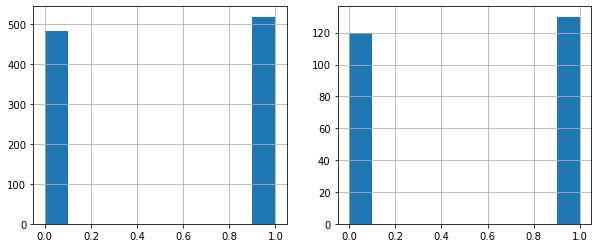

In [8]:
fig = plt.figure(figsize = (10,4))

plt.subplot(1,2, 1)
strat_train_set["Direction"].hist()

plt.subplot(1, 2, 2)
strat_test_set["Direction"].hist()

#fig.savefig("plots/11_sampling_train_test_sets.png")
plt.show()

### Standardize data (if needed)

In [10]:
std_X_train,  std_X_test = standard_data(X_train.copy(), X_test.copy())

## Models

### Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

# logreg.fit(X_train.values, y_train)
logreg.fit(std_X_train, y_train)

LogisticRegression()

In [12]:
logreg.score(X_test.values, y_test)

0.52

### Random forest

In [13]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
#clf.fit(x_train, y_train)
clf.fit(X_train, y_train)

RandomForestClassifier()

In [14]:
clf.score(X_test, y_test)

0.504

### XGBoost

In [47]:
from xgboost import XGBClassifier
import matplotlib
from matplotlib import pyplot

In [16]:
xgb =  XGBClassifier(nthread=-1)

In [17]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, ...)

In [18]:
xgb.score(X_test, y_test)

0.484

## Hyperparameter tunning

### Random forest

In [23]:
from sklearn.model_selection import GridSearchCV 

# search space
n_estimators = [10, 100, 200, 500]
max_depth = [None, 5, 10]
min_samples_split = [2, 3, 4]

# param_grid = [
#     {'n_estimators': [10, 100, 200, 500], "max_depth": [None, 5, 10], "min_samples_split": [2, 3, 4]}
# ]
param_grid = dict(n_estimators=n_estimators, max_depth = max_depth, min_samples_split=min_samples_split)
grid_search = GridSearchCV(clf, param_grid, cv=9, scoring="accuracy", return_train_score=True,  n_jobs=-1)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=9, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [10, 100, 200, 500]},
             return_train_score=True, scoring='accuracy')

In [24]:
final_clf = grid_search.best_estimator_

In [26]:
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.527018 using {'max_depth': 5, 'min_samples_split': 4, 'n_estimators': 10}
0.509947 (0.044659) with: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 10}
0.519001 (0.045334) with: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
0.518983 (0.043492) with: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
0.510001 (0.027505) with: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}
0.522031 (0.051592) with: {'max_depth': None, 'min_samples_split': 3, 'n_estimators': 10}
0.519028 (0.037125) with: {'max_depth': None, 'min_samples_split': 3, 'n_estimators': 100}
0.519966 (0.028035) with: {'max_depth': None, 'min_samples_split': 3, 'n_estimators': 200}
0.503977 (0.023852) with: {'max_depth': None, 'min_samples_split': 3, 'n_estimators': 500}
0.517071 (0.046235) with: {'max_depth': None, 'min_samples_split': 4, 'n_estimators': 10}
0.518000 (0.025481) with: {'max_depth': None, 'min_samples_split': 4, 'n_estimators': 100}
0.514961 (0

### XGBoost

#### Random search
We will be able to shrink the hyperparameter space where to search

In [75]:
from sklearn.model_selection import RandomizedSearchCV


n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]

random_grid = dict(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)

grid_random_search = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid, 
                        n_iter = 100, cv = 9, verbose=2, random_state=42, n_jobs = -1)

random_grid_result = grid_random_search.fit(X_train, y_train)

The total space of parameters 96 is smaller than n_iter=100. Running 96 iterations. For exhaustive searches, use GridSearchCV.


Fitting 9 folds for each of 96 candidates, totalling 864 fits


In [76]:
print("Best: %f using %s" % (random_grid_result.best_score_, random_grid_result.best_params_))

Best: 0.538985 using {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.001}


In [59]:
n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]
learning_rate = [0.0001, 0.001, 0.01, 0.1]#, 0.2, 0.3]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate)
#kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(xgb, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=9,
verbose=1)
grid_result = grid_search.fit(X_train, y_train)

Fitting 9 folds for each of 96 candidates, totalling 864 fits


In [60]:
final_xgb = grid_search.best_estimator_

In [62]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.692700 using {'learning_rate': 0.001, 'max_depth': 4, 'n_estimators': 150}
-0.693136 (0.000050) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 50}
-0.693127 (0.000098) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 100}
-0.693121 (0.000141) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 150}
-0.693115 (0.000182) with: {'learning_rate': 0.0001, 'max_depth': 2, 'n_estimators': 200}
-0.693098 (0.000084) with: {'learning_rate': 0.0001, 'max_depth': 4, 'n_estimators': 50}
-0.693055 (0.000165) with: {'learning_rate': 0.0001, 'max_depth': 4, 'n_estimators': 100}
-0.693014 (0.000246) with: {'learning_rate': 0.0001, 'max_depth': 4, 'n_estimators': 150}
-0.692975 (0.000327) with: {'learning_rate': 0.0001, 'max_depth': 4, 'n_estimators': 200}
-0.693173 (0.000150) with: {'learning_rate': 0.0001, 'max_depth': 6, 'n_estimators': 50}
-0.693202 (0.000293) with: {'learning_rate': 0.0001, 'max_depth': 6, 'n_estimators': 100}
-0.693236 (0.000438

In [77]:
# scores = np.array(means).reshape(len(max_depth), len(n_estimators))
# for i, value in enumerate(max_depth):
#     pyplot.plot(n_estimators, scores[i], label='depth: ' + str(value))
# pyplot.legend()
# pyplot.xlabel('n_estimators')
# pyplot.ylabel('Log Loss')
# pyplot.savefig('n_estimators_vs_max_depth.png')

### Store the best models

In [79]:
import joblib

In [84]:
joblib.dump(final_clf, "rf_joblib.dat")
joblib.dump(final_xgb, "xgb_joblib.dat")

['xgb_joblib.dat']

##### Example of load the models

In [81]:
loaded_rf = joblib.load("rf_joblib.dat")

## model evaluation

In [64]:
predicted_target, actual_target = evaluate_model(data, model=final_xgb, output_name=output_name)#logreg, output_name)

### Confusion matrix

Normalized confusion matrix


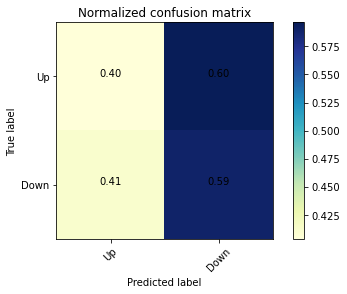

In [65]:
fig_conf_mat = plot_confusion_matrix(actual_target, predicted_target, classes = class_names)

### ROC curve

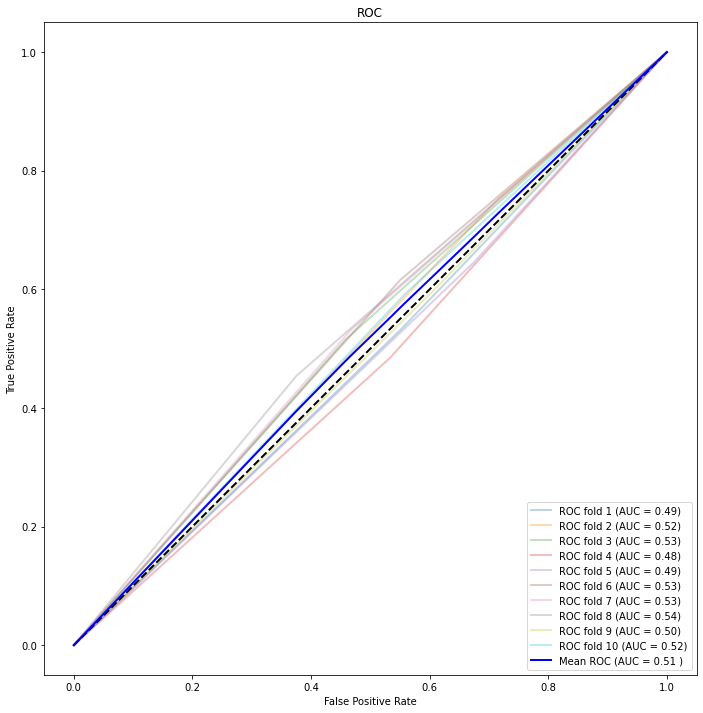

In [66]:
fig_roc_auc = plot_roc_auc(actual_target, predicted_target)

## Explainability

### Shap values
[Documentation](https://shap.readthedocs.io/en/latest/index.html)

In [39]:
import shap

e:\Programas\anaconda3\envs\RAndPython\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [67]:
explainer = shap.TreeExplainer(
    final_xgb, 
    X_train,
    model_output='probability'
)

In [68]:
shap_values = explainer.shap_values(X_train)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


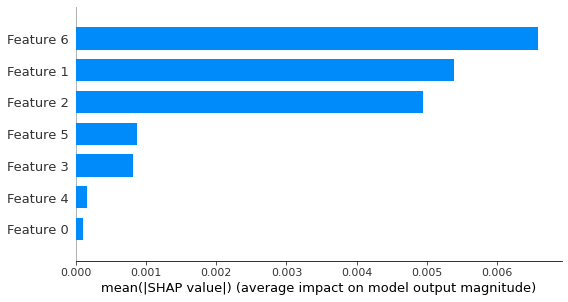

In [69]:
shap.summary_plot(shap_values, plot_type="bar")

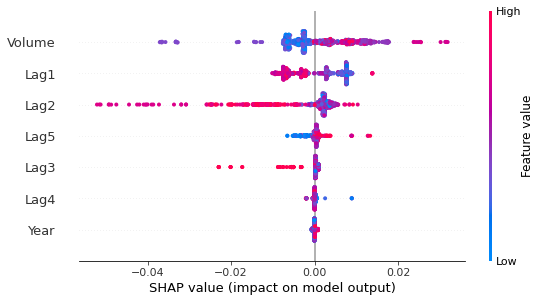

In [70]:
shap.summary_plot(shap_values, X_train)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


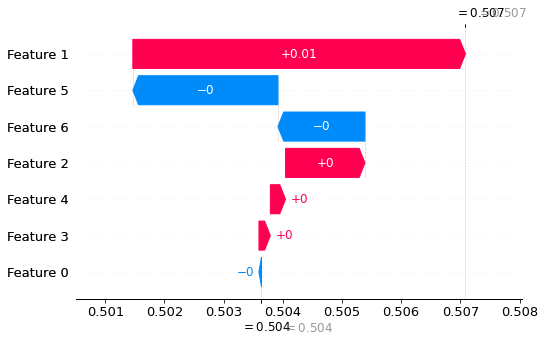

In [71]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[0])